[Used as a refererence](https://www.kaggle.com/hsinwenchang/vggface-baseline-197x197/)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['recognizing-faces-in-the-wild']


In [2]:
import tensorflow as tf
import keras
from random import choice, sample
from keras.preprocessing import image
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Subtract, Multiply
from keras.models import Model
from keras.optimizers import Adam
import keras.backend as K
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow


%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [3]:
pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-jdbj3bnu
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-jdbj3bnu
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=e63316000b626cef1a1f3a1c2af7979fa1ec0befff2303d73ecd79fa6d2538b6
  Stored in directory: /tmp/pip-ephem-wheel-cache-noml3jwm/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
Note: you may need to restart the kernel to use updated packages.


In [4]:
from keras_vggface.vggface import VGGFace
from keras_vggface import utils

In [5]:
relationships = pd.read_csv("../input/recognizing-faces-in-the-wild/train_relationships.csv")
test_df = pd.read_csv("../input/recognizing-faces-in-the-wild/sample_submission.csv")

In [6]:
def preprocess(filepath):
    img = cv2.imread(filepath)
    x = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = image.img_to_array(x)
    x = np.expand_dims(x, axis=0)
    x = utils.preprocess_input(x, version=1)
    x = x.reshape((224,224,3))
    return x

(224, 224, 3)
(224, 224, 3)


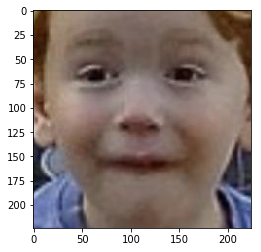

In [7]:
#visualizing a test set image
import cv2
ex = cv2.imread("../input/recognizing-faces-in-the-wild/test/face06124.jpg")
ex = cv2.cvtColor(ex, cv2.COLOR_BGR2RGB)
imshow(ex)
print(ex.shape)
ex_pre = preprocess("../input/recognizing-faces-in-the-wild/test/face06124.jpg")
print(ex_pre.shape)

In [8]:
#convolutional features
vggfeatures = VGGFace(include_top = False, input_shape = (224,224,3),pooling = 'avg')
for x in vggfeatures.layers[:]:
    x.trainable = False
base_model = vggfeatures


58916864/58909280 [==============================] - 1s 0us/step


In [9]:
base_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0         
__________

In [10]:
def baseline_model():
    input1 = Input(shape=(224,224,3))
    input2 = Input(shape=(224,224,3))
    
    x1 = base_model(input1)
    x2 = base_model(input2)
    
    x3 = Subtract()([x1, x2])
    x3 = Multiply()([x3, x3])

    x1_ = Multiply()([x1, x1])
    x2_ = Multiply()([x2, x2])
    x4 = Subtract()([x1_, x2_])
    x = Concatenate(axis=-1)([x4, x3])
    x = Dense(512, activation = 'relu', name = 'fc_final0')(x)
    x = Dense(64, activation = 'relu', name = 'fc_final1')(x)
    x = Dense(1, activation = 'sigmoid', name = 'preds')(x)
    
    model = Model(inputs = [input1,input2], outputs = x, name = 'Face_Sim')
    
    return model 

In [11]:
my_model = baseline_model()
my_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vggface_vgg16 (Model)           (None, 512)          14714688    input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
multiply_2 (Multiply)           (None, 512)          0           vggface_vgg16[1][0]              
          

In [12]:
train_base_path = '../input/recognizing-faces-in-the-wild/train/'
families = sorted(os.listdir(train_base_path))
print('We have {} families in the dataset'.format(len(families)))
print(families[:5])

We have 470 families in the dataset
['F0002', 'F0005', 'F0009', 'F0010', 'F0016']


In [13]:
members = {i:sorted(os.listdir(train_base_path+i)) for i in families}

In [14]:
test_path = '../input/recognizing-faces-in-the-wild/test/'
test_imgs_names = os.listdir(test_path)
print(test_imgs_names[:5])

['face04764.jpg', 'face05034.jpg', 'face02691.jpg', 'face03143.jpg', 'face02153.jpg']


In [15]:
from collections import defaultdict
from glob import glob
train_folders_path = "../input/recognizing-faces-in-the-wild/train/"
val_famillies = "F09"

all_images = glob(train_folders_path + "*/*/*.jpg")

train_images = [x for x in all_images if val_famillies not in x]
val_images = [x for x in all_images if val_famillies in x]

train_person_to_images_map = defaultdict(list)

ppl = [x.split("/")[-3] + "/" + x.split("/")[-2] for x in all_images]

for x in train_images:
    train_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

val_person_to_images_map = defaultdict(list)

for x in val_images:
    val_person_to_images_map[x.split("/")[-3] + "/" + x.split("/")[-2]].append(x)

In [16]:
relationships = list(zip(relationships.p1.values, relationships.p2.values))
relationships = [x for x in relationships if x[0] in ppl and x[1] in ppl]

train = [x for x in relationships if val_famillies not in x[0]]
val = [x for x in relationships if val_famillies in x[0]]

In [17]:
def gen(list_tuples, person_to_images_map, batch_size=16):
    ppl = list(person_to_images_map.keys())
    while True:
        batch_tuples = sample(list_tuples, batch_size // 2)
        labels = [1] * len(batch_tuples)
        while len(batch_tuples) < batch_size:
            p1 = choice(ppl)
            p2 = choice(ppl)

            if p1 != p2 and (p1, p2) not in list_tuples and (p2, p1) not in list_tuples:
                batch_tuples.append((p1, p2))
                labels.append(0)

        for x in batch_tuples:
            if not len(person_to_images_map[x[0]]):
                print(x[0])

        X1 = [choice(person_to_images_map[x[0]]) for x in batch_tuples]
        X1 = np.array([preprocess(x) for x in X1])

        X2 = [choice(person_to_images_map[x[1]]) for x in batch_tuples]
        X2 = np.array([preprocess(x) for x in X2])

        yield [X1, X2], labels

In [18]:
file_path = "weights.h5"

checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=20, verbose=1)

callbacks_list = [checkpoint, reduce_on_plateau]

my_model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

my_model.fit_generator(gen(train, train_person_to_images_map, batch_size=16), use_multiprocessing=True, validation_data=gen(val, val_person_to_images_map, batch_size=16), epochs=100, verbose=2, workers=4, callbacks=callbacks_list, steps_per_epoch=200, validation_steps=100)

Epoch 1/100


/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 33s - loss: 7.7128 - acc: 0.4841 - val_loss: 7.9093 - val_acc: 0.4794

Epoch 00001: val_acc improved from -inf to 0.47937, saving model to weights.h5
Epoch 2/100
 - 28s - loss: 7.5212 - acc: 0.4925 - val_loss: 7.7053 - val_acc: 0.4856

Epoch 00002: val_acc improved from 0.47937 to 0.48562, saving model to weights.h5
Epoch 3/100
 - 28s - loss: 7.3559 - acc: 0.5056 - val_loss: 7.7488 - val_acc: 0.4781

Epoch 00003: val_acc did not improve from 0.48562
Epoch 4/100
 - 27s - loss: 7.1440 - acc: 0.5075 - val_loss: 7.0607 - val_acc: 0.5169

Epoch 00004: val_acc improved from 0.48562 to 0.51687, saving model to weights.h5
Epoch 5/100
 - 28s - loss: 6.4334 - acc: 0.5447 - val_loss: 6.3542 - val_acc: 0.5544

Epoch 00005: val_acc improved from 0.51687 to 0.55437, saving model to weights.h5
Epoch 6/100
 - 28s - loss: 6.2600 - acc: 0.5619 - val_loss: 5.9488 - val_acc: 0.5906

Epoch 00006: val_acc improved from 0.55437 to 0.59062, saving model to weights.h5
Epoch 7/100
 - 28s - loss: 5.7481 - acc

In [19]:
test_folder = "../input/test/"


def chunker(seq, size=32):
    return (seq[pos:pos + size] for pos in range(0, len(seq), size))


from tqdm import tqdm

predictions = []

for batch in tqdm(chunker(test_df.img_pair.values)):
    X1 = [x.split("-")[0] for x in batch]
    X1 = np.array([preprocess(test_path + x) for x in X1])

    X2 = [x.split("-")[1] for x in batch]
    X2 = np.array([preprocess(test_path + x) for x in X2])

    pred = my_model.predict([X1, X2]).ravel().tolist()
    predictions += pred
for i in range(len(predictions)):
    if predictions[i] > 0.5:
        predictions[i] = 1
    else:
        predictions[i] = 0
test_df['is_related'] = predictions

test_df.to_csv("result.csv", index=False)

166it [01:09,  1.32it/s]
